# Testing Bloomberg Data Fetching from Configuration

This notebook demonstrates and tests the functionality of fetching Bloomberg data using configuration files. We'll explore:

1. Loading and validating configuration
2. Testing different data categories from config
3. Validating the fetched data
4. Exploring error cases and edge conditions

In [1]:
import sys
import os
from pathlib import Path
import yaml
import logging
import logging.config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta

# Set up project paths
notebook_dir = Path().absolute()
project_root = notebook_dir.parent
sys.path.append(str(project_root))

from src.core.bloomberg_fetcher import BloombergDataFetcher
from src.utils.csv_exporter import export_table_to_csv

In [2]:
def setup_logging():
    """Set up logging configuration."""
    config_path = project_root / 'config' / 'logging_config.yaml'
    
    # Create logs directory if it doesn't exist
    logs_dir = project_root / 'logs'
    logs_dir.mkdir(exist_ok=True)
    
    if config_path.exists():
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
            # Update log file paths to use absolute paths
            for handler in config['handlers'].values():
                if 'filename' in handler:
                    handler['filename'] = str(logs_dir / Path(handler['filename']).name)
            logging.config.dictConfig(config)
    else:
        logging.basicConfig(level=logging.INFO)
    
    data_pipeline_logger = logging.getLogger('data_pipeline')
    bloomberg_logger = logging.getLogger('bloomberg')
    validation_logger = logging.getLogger('validation')
    
    return data_pipeline_logger, bloomberg_logger, validation_logger

# Set up logging
data_pipeline_logger, bloomberg_logger, validation_logger = setup_logging()

## 1. Configuration Loading and Validation

First, let's examine the configuration file structure and validate its contents.

In [7]:
from pathlib import Path
import sys
sys.path.append('../')  # Add parent directory to path to import src modules

from src.utils.config_validator import load_and_validate_config

# Load and validate config
config_path = Path('../config/config.yaml')
config = load_and_validate_config(config_path)

# Access specific parts of the config
settings = config['settings']
spread_securities = config['sprds']['securities']
derivative_securities = config['derv']['securities']

# Example: Print all spread tickers and their custom names
print("\nSpread Securities:")
for security in spread_securities:
    print(f"{security['custom_name']}: {security['ticker']}")

# Example: Print all derivative tickers and their custom names
print("\nDerivative Securities:")
for security in derivative_securities:
    print(f"{security['custom_name']}: {security['ticker']}")

# Example: Print settings
print("\nSettings:")
for key, value in settings.items():
    print(f"{key}: {value}")

Configuration Summary:

Settings:
default_start_date: 2020-01-01
default_end_date: 
data_directory: data
log_directory: logs

Data Categories:
sprds:
  Field: INDEX_OAS_TSY_BP
  Securities: 2
    - cad_ig_oas: I05510CA Index
    - us_ig_oas: LUACTRUU Index
derv:
  Field: ROLL_ADJUSTED_MID_PRICE
  Securities: 2
    - cdx_ig: IBOXUMAE MKIT Curncy
    - cdx_hy: IBOXHYSE MKIT Curncy

Spread Securities:
cad_ig_oas: I05510CA Index
us_ig_oas: LUACTRUU Index

Derivative Securities:
cdx_ig: IBOXUMAE MKIT Curncy
cdx_hy: IBOXHYSE MKIT Curncy

Settings:
default_start_date: 2020-01-01
default_end_date: 
data_directory: data
log_directory: logs


## 2. Testing Individual Data Categories

Let's test fetching data for each category defined in the configuration.


Testing category: sprds

Data Summary for sprds:
Shape: (1210, 2)

First few rows:
            I05510CA Index  LUACTRUU Index
2020-01-02        104.2540         94.4853
2020-01-03        104.6904         95.9580
2020-01-06        104.6481         97.1875
2020-01-07        104.2790         97.2896
2020-01-08        103.5459         96.4948

Basic statistics:
       I05510CA Index  LUACTRUU Index
count     1210.000000     1210.000000
mean       135.636247      116.976915
std         28.563974       35.924485
min         98.167200       73.579800
25%        110.714275       90.761225
50%        131.728300      109.361350
75%        155.843400      132.537800
max        272.715500      381.077700


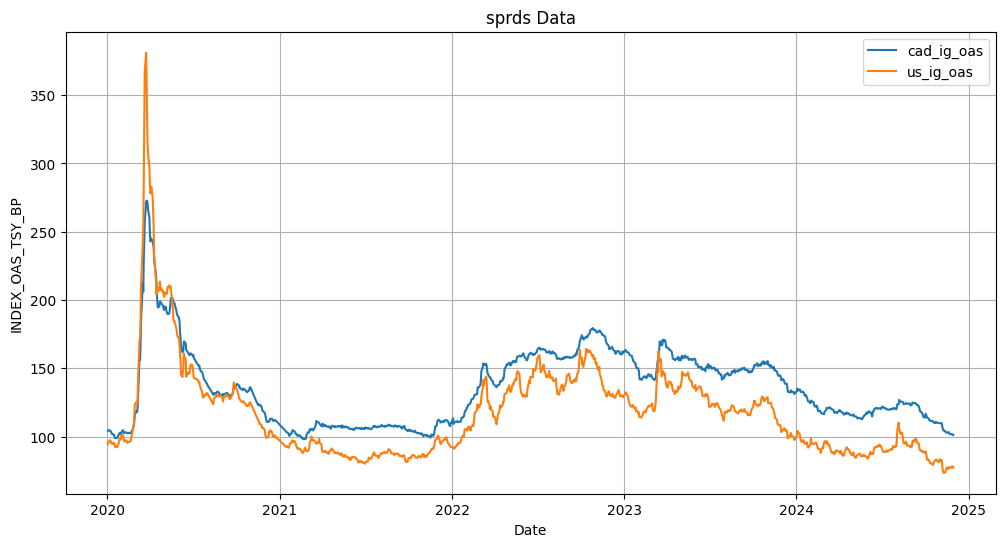


Testing category: derv

Data Summary for derv:
Shape: (1267, 2)

First few rows:
            IBOXUMAE MKIT Curncy  IBOXHYSE MKIT Curncy
2020-01-01                52.053               305.862
2020-01-02                50.966               300.478
2020-01-03                52.798               306.998
2020-01-06                52.958               306.958
2020-01-07                53.775               310.609

Basic statistics:
       IBOXUMAE MKIT Curncy  IBOXHYSE MKIT Curncy
count           1267.000000           1267.000000
mean              66.440066            403.955182
std               17.036526            100.421270
min               45.134000            277.971000
25%               52.915000            318.128000
50%               58.341000            374.855000
75%               76.488500            471.562500
max              151.417000            913.408000


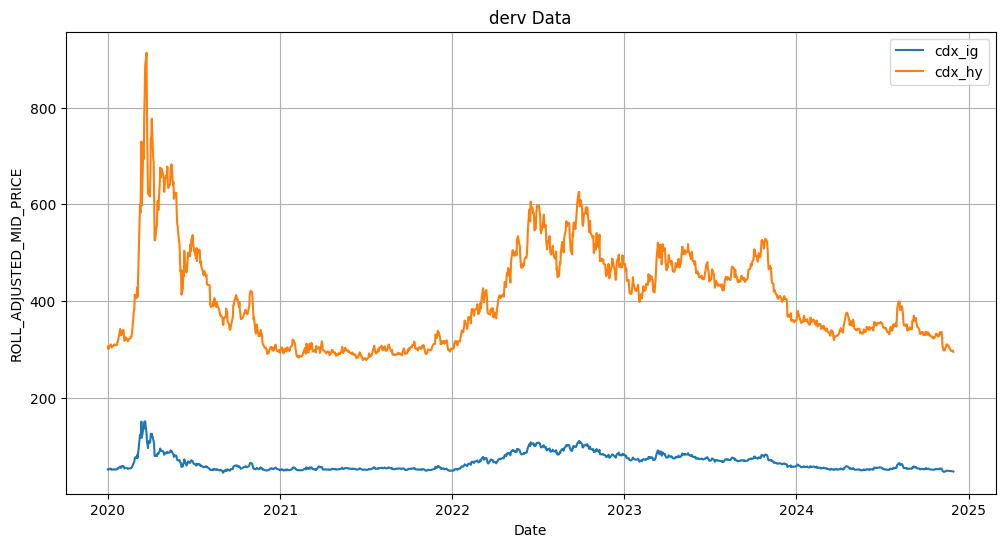

In [4]:
def test_category_fetch(category, config):
    """Test fetching data for a specific category."""
    bloomberg_logger.info(f"Testing data fetch for category: {category}")
    
    if category not in ['sprds', 'derv']:
        bloomberg_logger.error(f"Category {category} not found in config")
        return None
    
    # Extract tickers from the securities list for this category
    tickers = [security['ticker'] for security in config[category]['securities']]
    bloomberg_logger.info(f"Fetching data for {len(tickers)} tickers")
    
    try:
        fetcher = BloombergDataFetcher(
            tickers=tickers,
            fields=[config[category]['field']],  # Use the field specified for this category
            start_date=config['settings']['default_start_date'],
            logger=bloomberg_logger,
            config=config
        )
        
        data = fetcher.run_pipeline()
        
        # Print data summary
        print(f"\nData Summary for {category}:")
        print(f"Shape: {data.shape}")
        print("\nFirst few rows:")
        print(data.head())
        print("\nBasic statistics:")
        print(data.describe())
        
        # Plot the data
        plt.figure(figsize=(12, 6))
        for col in data.columns:
            # Use custom_name for the legend if available
            legend_name = next((sec['custom_name'] for sec in config[category]['securities'] 
                              if sec['ticker'] == col), col)
            plt.plot(data.index, data[col], label=legend_name)
        plt.title(f'{category} Data')
        plt.xlabel('Date')
        plt.ylabel(config[category]['field'])
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return data
        
    except Exception as e:
        bloomberg_logger.error(f"Error fetching data for {category}: {str(e)}")
        return None

# Test each category
results = {}
for category in ['sprds', 'derv']:
    print(f"\nTesting category: {category}")
    results[category] = test_category_fetch(category, config)

## 3. Data Validation and Analysis

Now let's analyze the quality of the fetched data.

In [5]:
def validate_data(category, data):
    """Validate and analyze the fetched data."""
    if data is None:
        validation_logger.warning(f"No data available for {category}")
        return
    
    validation_logger.info(f"Validating data for {category}")
    
    # Check for missing values
    missing = data.isnull().sum()
    if missing.any():
        print(f"\nMissing values in {category}:")
        print(missing[missing > 0])
    
    # Check for data continuity
    date_gaps = []
    dates = data.index.sort_values()
    for i in range(1, len(dates)):
        gap = (dates[i] - dates[i-1]).days
        if gap > 1:
            date_gaps.append((dates[i-1], dates[i], gap))
    
    if date_gaps:
        print(f"\nFound {len(date_gaps)} gaps in {category} data:")
        for start, end, gap in date_gaps[:5]:  # Show first 5 gaps
            print(f"Gap of {gap} days between {start} and {end}")
    
    # Check for outliers (using 3 standard deviations)
    for column in data.columns:
        mean = data[column].mean()
        std = data[column].std()
        outliers = data[abs(data[column] - mean) > 3*std]
        if not outliers.empty:
            print(f"\nPotential outliers in {column}:")
            print(outliers[column].head())
            
    # Add summary statistics
    print(f"\nSummary statistics for {category}:")
    print("\nData range:")
    print(f"Start date: {data.index.min()}")
    print(f"End date: {data.index.max()}")
    print(f"Total trading days: {len(data)}")
    
    # Calculate percentage of missing data
    total_possible_points = len(data.index) * len(data.columns)
    missing_points = data.isnull().sum().sum()
    completeness = (1 - missing_points/total_possible_points) * 100
    print(f"\nData completeness: {completeness:.2f}%")

# Validate all fetched data
for category, data in results.items():
    print(f"\nValidating {category}:")
    validate_data(category, data)


Validating sprds:

Found 257 gaps in sprds data:
Gap of 3 days between 2020-01-03 and 2020-01-06
Gap of 3 days between 2020-01-10 and 2020-01-13
Gap of 4 days between 2020-01-17 and 2020-01-21
Gap of 3 days between 2020-01-24 and 2020-01-27
Gap of 3 days between 2020-01-31 and 2020-02-03

Potential outliers in I05510CA Index:
2020-03-18    229.5958
2020-03-19    240.9029
2020-03-20    256.4023
2020-03-23    271.9288
2020-03-24    272.6706
Name: I05510CA Index, dtype: float64

Potential outliers in LUACTRUU Index:
2020-03-16    242.3955
2020-03-17    255.3763
2020-03-18    286.4574
2020-03-19    330.8586
2020-03-20    366.0580
Name: LUACTRUU Index, dtype: float64

Summary statistics for sprds:

Data range:
Start date: 2020-01-02
End date: 2024-11-29
Total trading days: 1210

Data completeness: 100.00%

Validating derv:

Found 258 gaps in derv data:
Gap of 3 days between 2020-01-03 and 2020-01-06
Gap of 3 days between 2020-01-10 and 2020-01-13
Gap of 3 days between 2020-01-17 and 2020-0

## 4. Testing Error Cases

Finally, let's test how the system handles various error conditions.

In [6]:
def test_error_cases():
    """Test various error conditions in data fetching."""
    validation_logger.info("Testing error cases")
    
    test_cases = [
        {
            'name': 'Invalid ticker',
            'tickers': ['INVALID_TICKER'],
            'fields': ['PX_LAST'],
            'start_date': '2020-01-01'
        },
        {
            'name': 'Future start date',
            'tickers': ['SPX Index'],
            'fields': ['PX_LAST'],
            'start_date': '2025-01-01'
        },
        {
            'name': 'Invalid field',
            'tickers': ['SPX Index'],
            'fields': ['INVALID_FIELD'],
            'start_date': '2020-01-01'
        }
    ]
    
    for case in test_cases:
        print(f"\nTesting: {case['name']}")
        try:
            fetcher = BloombergDataFetcher(
                tickers=case['tickers'],
                fields=case['fields'],
                start_date=case['start_date'],
                logger=bloomberg_logger
            )
            data = fetcher.run_pipeline()
            print("Unexpected success!")
        except Exception as e:
            print(f"Expected error: {str(e)}")

# Test error cases
test_error_cases()


Testing: Invalid ticker
Expected error: No data fetched from Bloomberg

Testing: Future start date
Expected error: No data fetched from Bloomberg

Testing: Invalid field
Expected error: No data fetched from Bloomberg
